In [22]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from predictor import ThroughputPredictor

# Data Loading

In [23]:
WINDOW_SIZE_MS = 100 # Number of milliseconds for each time window; TCP_INFO statistics are aggregated over this period
TIME_SERIES_LENGTH = 5 # Number of time series steps to consider for prediction

def load_dataset(file_path):
  df = pd.read_csv(file_path).dropna()
  df.sort_values(by=['TestID', 'ElapsedTime'], inplace=True)
  
  df['k'] = df['ElapsedTime'] // (WINDOW_SIZE_MS * 1000)
  agg_df = df.groupby(['TestID', 'k'], as_index=False).agg({
    'ElapsedTime': 'max',
    'BusyTime': 'max',
    'BytesSent': 'max',
    'BytesAcked': 'max',
    'BytesRetrans': 'max',
    'RTT': 'mean',
    'RTTVar': 'mean',
    'MinRTT': 'min',
    'RWndLimited': 'max',
    'SndBufLimited': 'max',
    'FinalSpeed': 'max',
  }, inplace=True)
  
  for i in range(1, TIME_SERIES_LENGTH):
    agg_df[f'ElapsedTime_{i}'] = agg_df.groupby('TestID')['ElapsedTime'].shift(i).fillna(0)
    agg_df[f'BusyTime_{i}'] = agg_df.groupby('TestID')['BusyTime'].shift(i).fillna(0)
    agg_df[f'BytesSent_{i}'] = agg_df.groupby('TestID')['BytesSent'].shift(i).fillna(0)
    agg_df[f'BytesAcked_{i}'] = agg_df.groupby('TestID')['BytesAcked'].shift(i).fillna(0)
    agg_df[f'BytesRetrans_{i}'] = agg_df.groupby('TestID')['BytesRetrans'].shift(i).fillna(0)
    agg_df[f'RTT_{i}'] = agg_df.groupby('TestID')['RTT'].shift(i).fillna(0)
    agg_df[f'RTTVar_{i}'] = agg_df.groupby('TestID')['RTTVar'].shift(i).fillna(0)
    agg_df[f'RWndLimited_{i}'] = agg_df.groupby('TestID')['RWndLimited'].shift(i).fillna(0)
    agg_df[f'SndBufLimited_{i}'] = agg_df.groupby('TestID')['SndBufLimited'].shift(i).fillna(0)
    
  agg_df = agg_df.groupby('TestID').apply(lambda x: x.iloc[TIME_SERIES_LENGTH:]).reset_index(drop=True)
  agg_df.drop(columns=['TestID'], inplace=True)
  labels = agg_df.pop('FinalSpeed')
  
  return agg_df, labels

In [24]:
features, labels = load_dataset('./dataset.csv')
features

,k,ElapsedTime,BusyTime,BytesSent,BytesAcked,BytesRetrans,RTT,RTTVar,MinRTT,RWndLimited,...,SndBufLimited_3,ElapsedTime_4,BusyTime_4,BytesSent_4,BytesAcked_4,BytesRetrans_4,RTT_4,RTTVar_4,RWndLimited_4,SndBufLimited_4
0,5,579234,575000,212785,93673,1418,121797.25,9535.5,100816,0,...,0.0,124037.0,119000.0,1.284700e+04,1.547000e+03,0.0,101050.00,28799.00,0.0,0.0
1,6,682398,678000,248235,93673,2836,163404.60,16453.2,100816,0,...,0.0,288933.0,284000.0,4.120700e+04,1.284700e+04,0.0,106504.25,16665.00,0.0,0.0
2,7,786233,782000,279431,93673,5672,221776.00,23703.8,100816,0,...,0.0,392226.0,388000.0,8.091100e+04,4.120700e+04,0.0,109021.75,6359.75,0.0,0.0
3,8,891832,887000,336151,133377,8508,274418.60,9798.4,100816,15000,...,0.0,496415.0,492000.0,1.603190e+05,7.240300e+04,0.0,109827.20,4563.20,0.0,0.0
4,9,998020,993000,402797,205695,12762,216210.20,11117.8,100816,74000,...,0.0,579234.0,575000.0,2.127850e+05,9.367300e+04,1418.0,121797.25,9535.50,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,92,9293469,9293000,1412073970,1304071780,106774202,1891.60,296.6,161,4146000,...,0.0,8787459.0,8788000.0,1.312769e+09,1.214030e+09,98098878.0,1579.80,218.40,3952000.0,0.0
22530,93,9314891,9315000,1418576562,1307920232,107103178,2422.00,843.0,161,4149000,...,0.0,8808776.0,8809000.0,1.316681e+09,1.214769e+09,98189630.0,2084.00,577.00,3959000.0,0.0
22531,95,9583439,9584000,1436655000,1324500906,108148244,1974.50,707.0,161,4364000,...,0.0,9099539.0,9100000.0,1.349074e+09,1.248059e+09,100265582.0,2280.40,344.00,4146000.0,0.0
22532,97,9789169,9789000,1447534832,1337624014,108847318,2000.50,429.0,161,4534000,...,0.0,9185733.0,9186000.0,1.375302e+09,1.271397e+09,103331298.0,1498.75,497.00,4146000.0,0.0


In [25]:
X, y = features.values, labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Throughput Predictor

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression = ThroughputPredictor(num_features=len(features.columns))
regression.to(device)
regression.fit(X_train, y_train, epochs=100, batch_size=16, learning_rate=0.001)

Epoch 1/100, Loss: 30017.550240346434
Epoch 2/100, Loss: 2865.180945429309
Epoch 3/100, Loss: 1779.0020233661119
Epoch 4/100, Loss: 1334.9147239321385
Epoch 5/100, Loss: 1123.1941757337559
Epoch 6/100, Loss: 1008.5803805200371
Epoch 7/100, Loss: 902.9068673629064
Epoch 8/100, Loss: 896.5814171625683
Epoch 9/100, Loss: 804.231961289961
Epoch 10/100, Loss: 768.1197077604143
Epoch 11/100, Loss: 728.2116935886669
Epoch 12/100, Loss: 742.6898180364838
Epoch 13/100, Loss: 728.9026354132994
Epoch 14/100, Loss: 699.0297363234823
Epoch 15/100, Loss: 709.622067889142
Epoch 16/100, Loss: 686.6876508870424
Epoch 17/100, Loss: 774.9314786778502
Epoch 18/100, Loss: 655.7238166298392
Epoch 19/100, Loss: 678.8646965936038
Epoch 20/100, Loss: 650.7461733271577
Epoch 21/100, Loss: 640.1537202647444
Epoch 22/100, Loss: 687.1797749507741
Epoch 23/100, Loss: 667.7051098032365
Epoch 24/100, Loss: 673.5299863925328
Epoch 25/100, Loss: 617.7197511411342
Epoch 26/100, Loss: 620.6807551529055
Epoch 27/100, Loss

ThroughputPredictor(
  (stack): Sequential(
    (0): Linear(in_features=47, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

## Evaluation

In [27]:
y_pred = regression.predict(X_test)
percent_error = np.abs((y_pred - y_test) / y_test) * 100

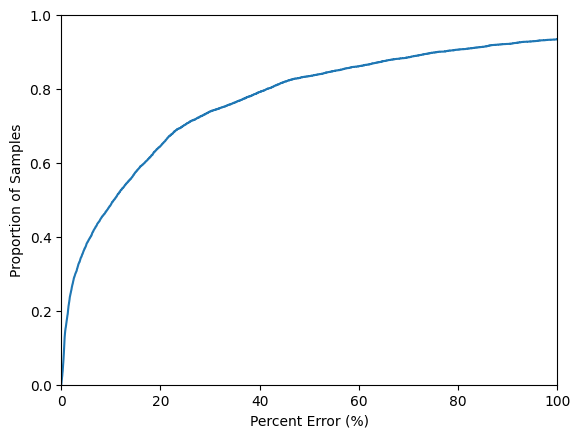

In [28]:
ax = plt.axes()
ax.ecdf(percent_error, label='Percent Error')
ax.set_xlabel('Percent Error (%)')
ax.set_ylabel('Proportion of Samples')
plt.xlim(0, 100)
plt.show()

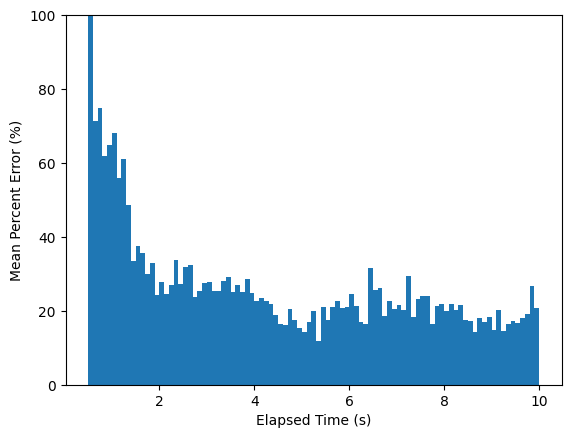

In [29]:
k_vals, inv = np.unique(scaler.inverse_transform(X_test)[::, 0], return_inverse=True)
ax = plt.axes()
ax.bar(k_vals * WINDOW_SIZE_MS/1000.0, np.bincount(inv, weights=percent_error) / np.bincount(inv), width=WINDOW_SIZE_MS/1000.0, align='edge')
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Mean Percent Error (%)')
ax.set_ylim(0, 100)
plt.show()